<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 380 (delta 117), reused 97 (delta 67), pack-reused 171
Receiving objects: 100% (380/380), 55.95 MiB | 23.79 MiB/s, done.
Resolving deltas: 100% (178/178), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27628 sha256=ce9b34d693a1c4bed71ee89bd0bd1fe9c534669b5b07598d72027c8be42f72ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-ktkpxt4s/wheels/55/59/29/0fb1c6356521

In [2]:
from dul_2021.utils.hw11_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

## Main classes

In [4]:
class ConvReluBN(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=(3, 3), stride=2, padding=1):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(in_features, out_features, kernel_size, stride, padding),
                              nn.BatchNorm2d(out_features),
                              nn.ReLU())

  def forward(self, x):
    return self.conv(x)

In [15]:
class Encoder(nn.Module):
  def __init__(self, lat_dim=128):
    super().__init__()
    self.conv = nn.Sequential(ConvReluBN(1, 32, stride=1),
                              ConvReluBN(32, 64),
                              ConvReluBN(64, 128),
                              ConvReluBN(128, 128),
                              ConvReluBN(128, 128),
                              ConvReluBN(128, 128))
    
    self.lin = nn.Sequential(nn.Flatten(),
                             nn.Linear(128, 128),
                             nn.ReLU(),
                             nn.Linear(128, lat_dim))

  def forward(self, x):
    x = self.conv(x)
    return self.lin(x)

In [16]:
class Predictor(nn.Module):
  def __init__(self, lat_dim=128):
    super().__init__()
    self.lin = nn.Sequential(nn.Linear(lat_dim, 256),
                             nn.ReLU(),
                             nn.Linear(256, 256),
                             nn.ReLU(),
                             nn.Linear(256, lat_dim))

  def forward(self, x):
    return self.lin(x)    

In [17]:
def update_teacher(T, S, τ):
  for (_, p), (_, q) in zip(T.named_parameters(), S.named_parameters()):
    p.data = τ * p.data + (1 - τ) * q.data 

## Define model and hyperparameters

In [18]:
batch_size = 128
n_epochs = 20
lat_dim = 128
τ = 0.99

In [19]:
encoder = Encoder(lat_dim=lat_dim)
student = nn.Sequential(encoder,
                        Predictor(lat_dim=lat_dim)).to(device)

teacher = Encoder(lat_dim=lat_dim).to(device)

In [20]:
from torch.optim import Adam

opt = Adam(student.parameters(), 1e-4)

for p in teacher.parameters():
  p.requires_grad = False

## Transformations

In [21]:
from torchvision import transforms

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomResizedCrop(size=28, scale=(0.5, 1.0)),
                                transforms.Normalize((-1,), (2.0,)),
                                transforms.ColorJitter(0.3, 0., 0., 0.3),
                                transforms.Normalize((0.5,), (0.5,))])

## Load data

In [22]:
from torch.utils.data import DataLoader

train_mnist, _ = get_data('MNIST')
train_data = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)

## Train loop

In [23]:
from torch.nn.functional import cosine_similarity

student.train()
teacher.train()

loss_record = []

for epoch in range(n_epochs):
  for h, _ in train_data:
    x = student(transform(h).to(device))
    y = teacher(transform(h).to(device))
    
    loss = - cosine_similarity(x, y).mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    update_teacher(teacher, student, τ)
    
    loss_record.append(-loss.item())

  print(f"Epoch : {epoch}")
  print(f"\t loss = {np.sum(loss_record[-100:])}")

Epoch : 0
	 loss = 94.76131165027618
Epoch : 1
	 loss = 97.18857562541962
Epoch : 2
	 loss = 98.36413019895554
Epoch : 3
	 loss = 98.63652938604355
Epoch : 4
	 loss = 98.72686445713043
Epoch : 5
	 loss = 98.5866824388504
Epoch : 6
	 loss = 98.67767333984375
Epoch : 7
	 loss = 98.61375427246094
Epoch : 8
	 loss = 98.7637950181961
Epoch : 9
	 loss = 98.8867774605751
Epoch : 10
	 loss = 98.86015719175339
Epoch : 11
	 loss = 98.93360912799835
Epoch : 12
	 loss = 98.82282078266144
Epoch : 13
	 loss = 98.87765341997147
Epoch : 14
	 loss = 98.98671901226044
Epoch : 15
	 loss = 98.99140584468842
Epoch : 16
	 loss = 98.96576648950577
Epoch : 17
	 loss = 98.93971699476242
Epoch : 18
	 loss = 98.83213865756989
Epoch : 19
	 loss = 98.89199459552765


## Results

In [26]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    encoder.eval()
    model = encoder.to("cpu")
    return np.array(loss_record), model

mean classification accuracy=0.8824


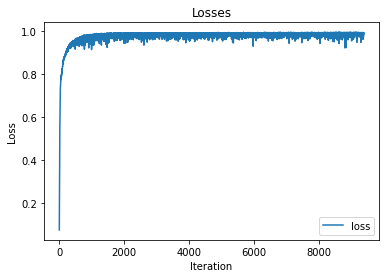

In [27]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

## Main classes

In [26]:
class Encoder(nn.Module):
  def __init__(self, lat_dim=128):
    super().__init__()
    self.conv = nn.Sequential(ConvReluBN(3, 32, stride=1),
                              ConvReluBN(32, 64),
                              ConvReluBN(64, 128),
                              ConvReluBN(128, 128),
                              ConvReluBN(128, 128),
                              ConvReluBN(128, 128))
    
    self.lin = nn.Sequential(nn.Flatten(),
                             nn.Linear(128, 128),
                             nn.ReLU(),
                             nn.Linear(128, lat_dim))

  def forward(self, x):
    x = self.conv(x)
    return self.lin(x)

In [27]:
class Projector(nn.Module):
  def __init__(self, lat_dim=128):
    super().__init__()
    self.lin = nn.Sequential(nn.Linear(lat_dim, 256),
                             nn.ReLU(),
                             nn.Linear(256, 256),
                             nn.ReLU(),
                             nn.Linear(256, lat_dim))

  def forward(self, x):
    return self.lin(x)

## Define model and hyperparameters

In [28]:
batch_size = 128
n_epochs = 20
lat_dim = 128
λ = 1e-2

In [29]:
from torch.optim import Adam

encoder = Encoder(lat_dim=lat_dim)
network = nn.Sequential(encoder,
                        Projector(lat_dim=lat_dim)).to(device)

opt = Adam(network.parameters(), 5e-4)

## Transformation

In [30]:
from torchvision import transforms

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomResizedCrop(size=32, scale=(0.5, 1.0)),
                                transforms.Normalize((-1,), (2.0,)),
                                transforms.ColorJitter(0.3, 0., 0., 0.3),
                                transforms.Normalize((0.5,), (0.5,))])

## Load data

In [31]:
from torch.utils.data import DataLoader

train_cifar, _ = get_data('CIFAR10')
train_data = DataLoader(train_cifar, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Train loop

In [32]:
from torch.nn.functional import normalize

loss_record = []

network.train()

for epoch in range(n_epochs):
  for x, _ in train_data:
    t1 = transform(x).to(device)
    t2 = transform(x).to(device)

    z1 = normalize(network(t1), dim=0).T
    z2 = normalize(network(t2), dim=0)

    C = torch.matmul(z1, z2)
    loss = (torch.diag(C) - 1) ** 2 - λ * torch.diag(C) ** 2
    loss = loss.sum()
    loss += λ * (C ** 2).sum()

    opt.zero_grad()
    loss.backward()
    opt.step()

    loss_record.append(loss.item())

  print(f"Epoch : {epoch}")
  print(f"\t loss = {np.sum(loss_record[-100:])}")

Epoch : 0
	 loss = 790.8588862419128
Epoch : 1
	 loss = 589.3625116348267
Epoch : 2
	 loss = 552.4876806735992
Epoch : 3
	 loss = 508.25109791755676
Epoch : 4
	 loss = 469.17368507385254
Epoch : 5
	 loss = 438.33988666534424
Epoch : 6
	 loss = 410.48417472839355
Epoch : 7
	 loss = 361.6979064941406
Epoch : 8
	 loss = 422.49570083618164
Epoch : 9
	 loss = 383.03772139549255
Epoch : 10
	 loss = 373.9475407600403
Epoch : 11
	 loss = 361.2076053619385
Epoch : 12
	 loss = 306.1575140953064
Epoch : 13
	 loss = 318.8007016181946
Epoch : 14
	 loss = 308.9542453289032
Epoch : 15
	 loss = 357.3473677635193
Epoch : 16
	 loss = 280.6172536611557
Epoch : 17
	 loss = 296.1301555633545
Epoch : 18
	 loss = 340.8662950992584
Epoch : 19
	 loss = 276.3048540353775


## Results

In [35]:
def q2(train_data, useless_argument):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    encoder.eval()
    model = encoder.to("cpu")
    return np.array(loss_record), model

Files already downloaded and verified
Files already downloaded and verified
mean classification accuracy=0.4101


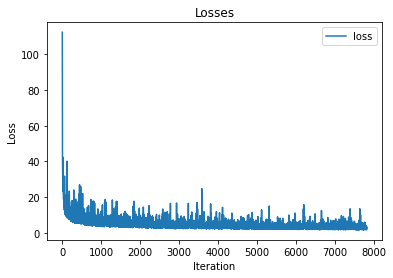

In [46]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)